In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imageio
import math
from skimage.color import rgb2gray

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Introduction

Ordered dithering is an image dithering algorithm commonly used to display a continuous image on a display of smaller color depth. The idea is simple, given an input image, the algorithm reduces the number of colors by applying a pixel-wise thresholding operation. Based on a given mask, some pixels of the images are set to 0 and others to 255. As a result, we have an image with 2 colors, black and white, that can be represented with only 1 bit.

In [3]:
# Load a grayscale image
original_img = cv2.imread('./assets/monarch.pgm', 0)
print("Image shape:",original_img.shape)

height, width = original_img.shape[0:2]

print("Min value:",np.min(original_img))
print("Max value:",np.max(original_img))

Image shape: (512, 768)
Min value: 17
Max value: 244


In [4]:
# implementing basic thresholding
threshold_img = original_img > 128

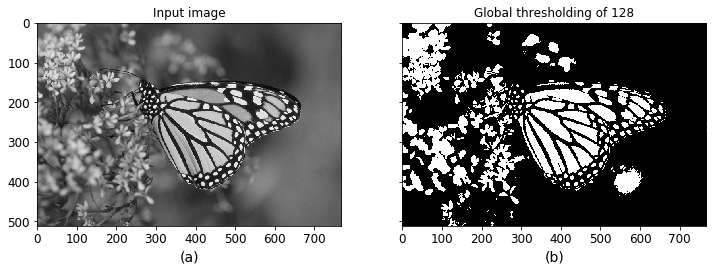

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12,10))
ax1.imshow(original_img, cmap='gray')
ax1.set_title('Input image')
ax1.set_xlabel("(a)")
ax2.imshow(threshold_img, cmap='gray')
ax2.set_title('Global thresholding of 128')
ax2.set_xlabel("(b)")
plt.show()

In [6]:
def MAE(image, target):
    return np.mean(np.abs(image - target))

In [7]:
print("Mean Absolute Error (MAE) uniform thresholding:",MAE(original_img,threshold_img))

Mean Absolute Error (MAE) uniform thresholding: 106.8135477701823


In [8]:
def normalize_kernel(kernel):
    return 255 * (kernel + 0.5) / (kernel.shape[0] * kernel.shape[1])

In [9]:
M44 = np.array([[0, 12, 3, 15],[8, 4, 11, 7],[2, 14, 1, 13],[10, 6, 9, 5]])
M33 = np.array([[6,8,4],[1,0,3],[5,2,7]])

M33 = normalize_kernel(M33)
M44 = normalize_kernel(M44)

print(M33)
print(M44)

[[184.16666667 240.83333333 127.5       ]
 [ 42.5         14.16666667  99.16666667]
 [155.83333333  70.83333333 212.5       ]]
[[  7.96875 199.21875  55.78125 247.03125]
 [135.46875  71.71875 183.28125 119.53125]
 [ 39.84375 231.09375  23.90625 215.15625]
 [167.34375 103.59375 151.40625  87.65625]]


In [10]:
def image_normalizer(image, a, b):
    min_ = np.min(image)
    max_ = np.max(image)
    return (b-a) * ((image - min_) / (max_ - min_)) + a

In [11]:
def image_padding(img, kernel):

    h,w = img.shape[:2]
    m,n = kernel.shape[:2]
    
    # pad image with zeros so that the output halftone image has the same dimensons as the input image 
    diff_h = h % m
    pad_height = 0
    pad_width = 0

    if diff_h > 0:
        pad_height = m - diff_h

    diff_w = w % n

    if diff_w > 0:
        pad_width = n - diff_w

    return np.pad(img, ((0, pad_height), (0, pad_width)), 'constant', constant_values=0)

In [12]:
def create_halftoning_mask(img, kernel):
    
    m,n = kernel.shape[0:2]
    print("Kernel shape:", m,n)
    
    m1 = math.floor(img.shape[0]/m)
    n1 = math.floor(img.shape[1]/n)
    
    mask = np.tile(kernel, (m1, n1))
    return mask

In [13]:
def halftoning(img, kernel):
    img = image_padding(img, kernel)
    print("New image shape:",img.shape)
    
    # create mask 
    mask = create_halftoning_mask(img, kernel)
    print("Mask shape:",mask.shape)
    
    res = img  > mask
    return res

In [14]:
res_m33 = halftoning(original_img, M33)
res_m33 = res_m33[:height, :width] * 255

res_m44 = halftoning(original_img, M44)
res_m44 = res_m44[:height, :width] * 255

New image shape: (513, 768)
Kernel shape: 3 3
Mask shape: (513, 768)
New image shape: (512, 768)
Kernel shape: 4 4
Mask shape: (512, 768)


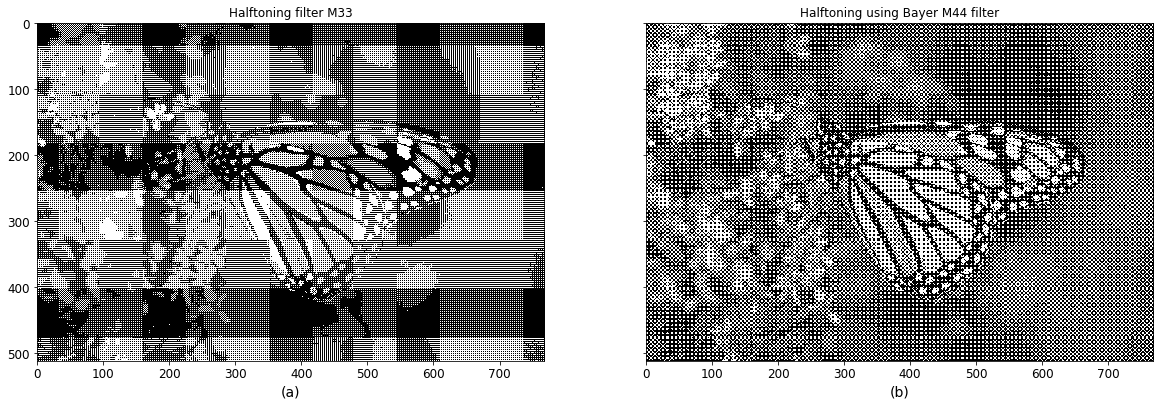

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20,10))
ax1.imshow(res_m33, cmap='gray')
ax1.set_title('Halftoning filter M33')
ax1.set_xlabel("(a)")

ax2.imshow(res_m44, cmap='gray')
ax2.set_title('Halftoning using Bayer M44 filter')
ax2.set_xlabel("(b)")
plt.show()

In [16]:
print("Halftoning M33 MAE:",MAE(original_img,res_m33))
print("Halftoning M44 MAE:",MAE(original_img,res_m44))

Halftoning M33 MAE: 110.82555135091145
Halftoning M44 MAE: 110.9035161336263


In [17]:
print("Min value:",np.min(original_img))
print("Max value:",np.max(original_img))

Min value: 17
Max value: 244


However, as one can see, there are some limitations to this method. Part of the problem with these halftoning masks is that our eyes easily grasp the patterns/regularities left off by the binarization process.

Let's compare the results produced by mask M33 and the Bayer filter M44. Using M33, we can clearly see very strong checkerboard artifacts on the resulting image. It is also clear that the Bayer mask outputs better perceptual results. It is important to note that perceptual results can be driven by some factors such as the pattern of the mask and its size.

Still, although the Bayer mask do output a better perceptual result, it still leaves these grid-like artifacts of black and white pixels. 

Intuitively, we still want to have fewer white dots on very darker areas. Yet, we would get better results if managed to get rid of the regularity/pattern at which the white pixels are drawn. That is the idea behind, Error diffusion dithering.

In [18]:
# n = 4

# D2 = np.array([[0,2],[3,1]])
# Un = np.ones((n,n))
# print(D2)
# print(Un)

M88 = np.array([[0,48,12,60,3,51,15,64],
               [32,16,44,28,35,19,47,31],
               [8,56,4,52,11,59,7,55],
               [40,24,36,20,43,27,39,23],
               [2,50,14,62,1,49,13,61],
               [34,18,46,30,33,17,45,29],
               [10,58,6,54,9,57,5,53],
               [42,26,38,22,41,25,37,21]])

M88 = normalize_kernel(M88)

New image shape: (512, 768)
Kernel shape: 8 8
Mask shape: (512, 768)


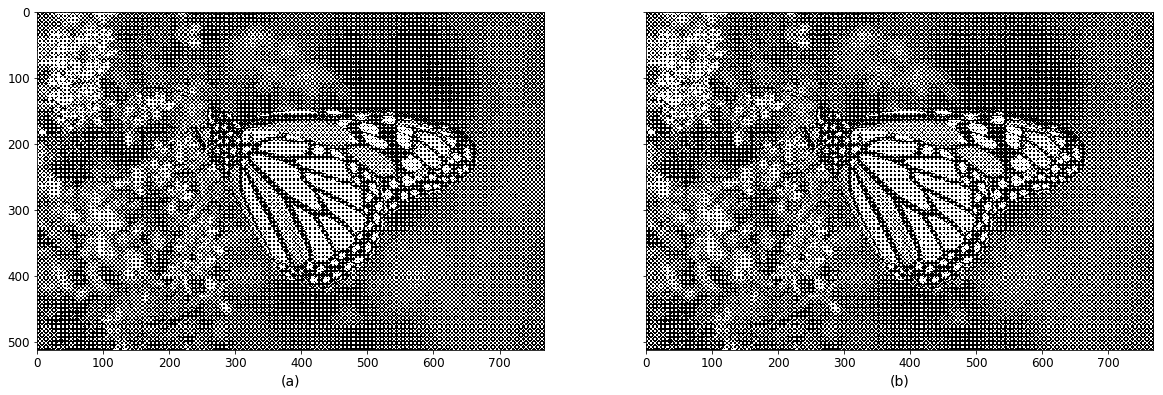

In [19]:
res_m88 = halftoning(original_img, M88)
res_m88 = res_m88[:height, :width] * 255

fig, (ax2, ax3) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20,10))
ax2.imshow(res_m44, cmap='gray')
ax2.set_xlabel("(a)")

ax3.imshow(res_m88, cmap='gray')
ax3.set_xlabel("(b)")
plt.show()

## Halftoning Intuition

To understand how halftoning works, let's take a look at a toy example. Consider the halftoning kernel M44 defined above. The M44 kernel is known as the Bayer halftoning filter. If we look carefully at M44, we will see that it follows a well-defined pattern. That is, the values of 0,1,2,3...15 in the kernel are arranged in a pattern that looks like small crosses.

To validate this intuition, let's apply the thresholding Bayer filter to a set of image patches with constant intensity values. For each patch, let's evaluate the outcome and check if it matches our feelings.

In [20]:
a = np.ones((4,4))
I_10 = a * 10
I_30 = a * 30
I_40 = a * 40
I_60 = a * 60
I_90 = a * 90

For the first image patch, we choose a constant pixel value of 10. Note that an intensity value of 10 makes up for a very dark image patch (considering pixel range from 0 to 255). As a result, after applying the halftoning Bayer mask, we should expect much more dark pixels in the result.

As we suspected, in Figure X (a), only 1 pixel (out of 16 total) got lighted up - that is only 6.25% of the total image pixels. Now, if we progressively increase the intensity of the patch image, that is, if we make it more and more lighter (by increasing its pixel intensities), we should anticipate that the number of dark pixels would diminish. That is exactly what Figure X (b),(c), (d) and (e) gives us. As we increase the pixel intensities of the image patch from 30 to 90, the number of darker pixels gets smaller. Also, note the pattern at which the kernel lights up the white pixels - it looks like an X shape!

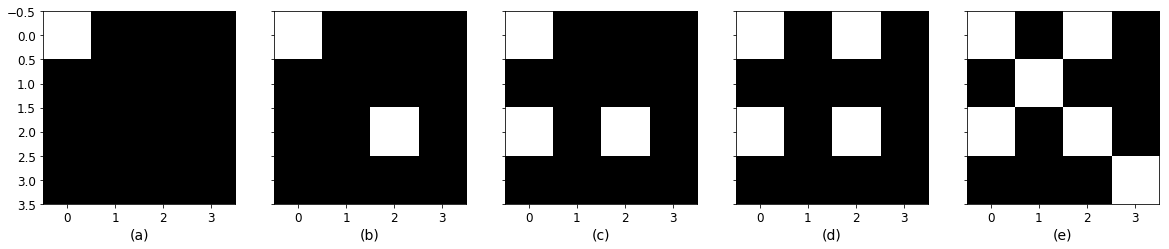

In [21]:
fig, axs = plt.subplots(1, 5, sharex='col', sharey='row', figsize=(20,10))
axs[0].imshow(I_10 > M44, cmap='gray')
axs[0].set_xlabel("(a)")

axs[1].imshow(I_30 > M44, cmap='gray')
axs[1].set_xlabel("(b)")

axs[2].imshow(I_40 > M44, cmap='gray')
axs[2].set_xlabel("(c)")

axs[3].imshow(I_60 > M44, cmap='gray')
axs[3].set_xlabel("(d)")

axs[4].imshow(I_90 > M44, cmap='gray')
axs[4].set_xlabel("(e)")

plt.show()

Now let's consider an image half black and half white pixels (a binary image). If we apply the Bayer mask to it, we should foresee no changes at all to the input image. In other words, the first half of the image, only composed with 0s would not be activated by the mask. That follows because, in this region of the image, all of the pixel values are smaller than the values of the kernel. Likewise, the other half of the image, composed solely with white (255) pixel values should all be activated (since they are all greater than the respective threshold values from the filter).

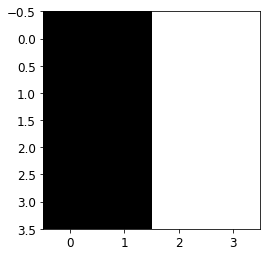

In [37]:
a = np.array(([0,0,255,255],[0,0,255,255],[0,0,255,255],[0,0,255,255]))
plt.imshow(a, cmap="gray")

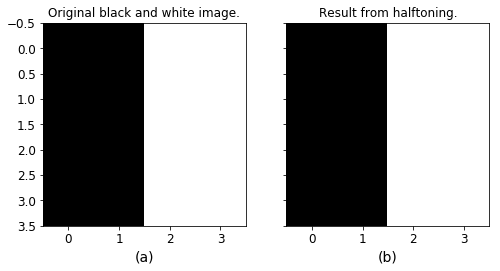

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8,8))

ax1.set_title("Original black and white image.")
ax1.imshow(a, cmap="gray")
ax1.set_xlabel("(a)")

ax2.set_title("Result from halftoning.")
ax2.imshow(a > M44, cmap="gray")
ax2.set_xlabel("(b)")

plt.show()

## Error-diffusion dithering

Note that in our previous attempts, we quantized each pixel independently. Put it differently, the process of assigning a 0 or a 255 to a given pixel was a function of that pixel alone. 

The main idea with error diffusion is that we quantize each pixel using a neighborhood operation. For each quantized pixel, we push the residual (error) to the pixels in the neighborhood that will be quantized next. Here the quantization process is a simple thresholding. And the error is simply the difference between the quantized pixel and the pixel from the image. This way, we minimize the overall average error between the quantized and the original input image.

Once we calculate the residual for a given pixel, we proportionally distribute the error to the neighboring pixels in the image. This proportion may vary. Here, we analyze the Floyd and Steinberg method. Basically, this method proposes a way to push the error forward to the neighboring pixels. Figure X describes how Floyd and Steinberg proposed to distribute the error.

Note that when we push the error forward, we are really changing the pixel intensities of the input image. Thus, as we continue this process, eventually, some pixel will be changed so that it exceeds the threshold value of 128. If this occurs, we set this pixel to 255 (white). It is important to note that in this situation, the residual will be negative. That is, the residual defined as 255 minus the current pixel value will likely be below zero. As a consequence, the error that is pushed forward will still change the neighboring pixels. However, this time, it will actually decrease their intensity values - which in turn could prevent some pixel to be above the threshold and to become white. 

In summary, instead of having a well-defined pattern that controls which pixels turn black or white, the process is governed by the error that is produced by the quantization of a given pixel. 

If we zoom in to a very dark portion of the quantized image, we can see that the distribution of the white dots follows our initial assumptions. They are sparse and yet they do not obey a specific pattern. Likewise, if we zoom in to a lighter region of the image, the distribution of dark pixels is now sparse and with no regularity. Much better results.

## Intuition

In [24]:
binary = np.zeros((2,3))
a = np.ones([4,5])

In [25]:
a = a * 64 
print(I_10)

[[10. 10. 10. 10.]
 [10. 10. 10. 10.]
 [10. 10. 10. 10.]
 [10. 10. 10. 10.]]


Current pixel: 64.0
[[64. 64. 64. 64. 64.]
 [64. 64. 92. 64. 64.]
 [76. 84. 68. 64. 64.]
 [64. 64. 64. 64. 64.]]


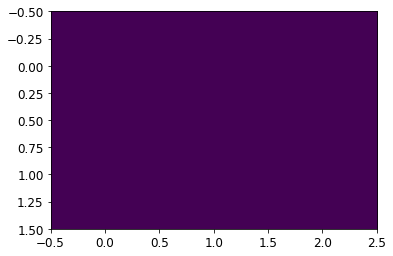

Current pixel: 92.0
[[ 64.    64.    64.    64.    64.  ]
 [ 64.    64.    92.   104.25  64.  ]
 [ 76.   101.25  96.75  69.75  64.  ]
 [ 64.    64.    64.    64.    64.  ]]


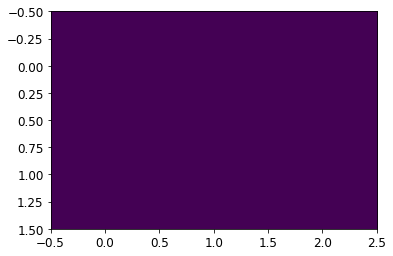

Current pixel: 104.25
[[ 64.        64.        64.        64.        64.      ]
 [ 64.        64.        92.       104.25     109.609375]
 [ 76.       101.25     116.296875 102.328125  70.515625]
 [ 64.        64.        64.        64.        64.      ]]


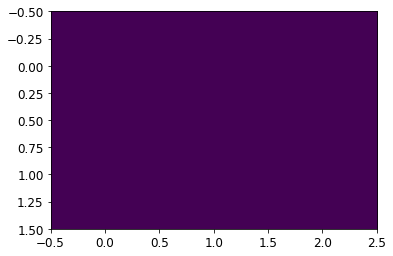

Current pixel: 101.25
[[ 64.        64.        64.        64.        64.      ]
 [ 64.        64.        92.       104.25     109.609375]
 [ 76.       101.25     160.59375  102.328125  70.515625]
 [ 82.984375  95.640625  70.328125  64.        64.      ]]


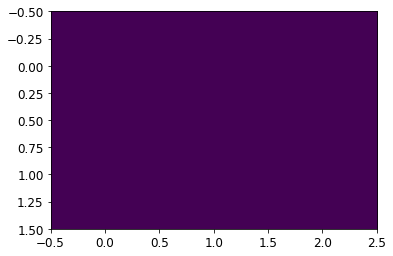

Current pixel: 160.59375
[[ 64.          64.          64.          64.          64.        ]
 [ 64.          64.          92.         104.25       109.609375  ]
 [ 76.         101.25       160.59375     61.02539062  70.515625  ]
 [ 82.984375    77.93945312  40.82617188  58.09960938  64.        ]]


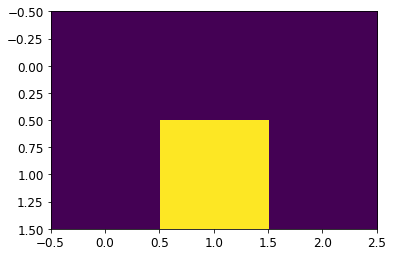

Current pixel: 61.025390625
[[ 64.          64.          64.          64.          64.        ]
 [ 64.          64.          92.         104.25       109.609375  ]
 [ 76.         101.25       160.59375     61.02539062  97.2142334 ]
 [ 82.984375    77.93945312  52.26843262  77.17004395  67.81408691]]


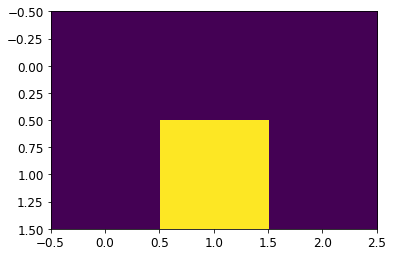

In [26]:
for i in range(1,a.shape[0]-1):

    for j in range(1,a.shape[1]-1):
        print("Current pixel:",a[i,j])
        # perform pixel quantization
        if a[i,j] < 128:
            binary[i-1,j-1] = 0
        else:
            binary[i-1,j-1] = 255

        error = a[i,j] - binary[i-1,j-1]

        # distribute the error to the adjacent pixels

        a[i,j+1] += (7/16)*error
        a[i+1,j-1] += (3/16)*error
        a[i+1,j] += (5/16)*error
        a[i+1,j+1] += (1/16)*error
        
        print(a)
        plt.imshow(binary)
        plt.show()

In [27]:
# original_img = imageio.imread('./assets/sonnet.pgm')
# Load an color image in grayscale
original_img = cv2.imread('./assets/peppers.pgm', 0)
print("Image shape:",original_img.shape)

Image shape: (594, 623)


In [28]:
def error_diffusion_dithering(img, zigzag):
  
  binary = np.zeros(img.shape)

  img = np.pad(img, (1,1), 'constant', constant_values=0)
  print("Image shape:", img.shape)

  for i in range(1,img.shape[0]-1):
  
    col_ids = range(1,img.shape[1]-1)
    
    if zigzag:
      if i % 2 != 0:
        # reverse the row order
        col_ids = reversed(col_ids)

    for j in col_ids:

      # perform pixel quantization
      if img[i,j] < 128:
        binary[i-1,j-1] = 0
      else:
        binary[i-1,j-1] = 255

      error = img[i,j] - binary[i-1,j-1]

      # distribute the error to the adjacent pixels
      img[i,j+1] += (7/16)*error
      img[i+1,j-1] += (3/16)*error
      img[i+1,j] += (5/16)*error
      img[i+1,j+1] += (1/16)*error
  return binary * 255

In [29]:
out1 = error_diffusion_dithering(original_img, zigzag=True)
out2 = error_diffusion_dithering(original_img, zigzag=False)

Image shape: (596, 625)
Image shape: (596, 625)


In [30]:
cv2.imwrite("output/err-diff-1.jpg", out1, [cv2.IMWRITE_PNG_BILEVEL, 1])
cv2.imwrite("output/err-diff-2.jpg", out2, [cv2.IMWRITE_PNG_BILEVEL, 1])

True

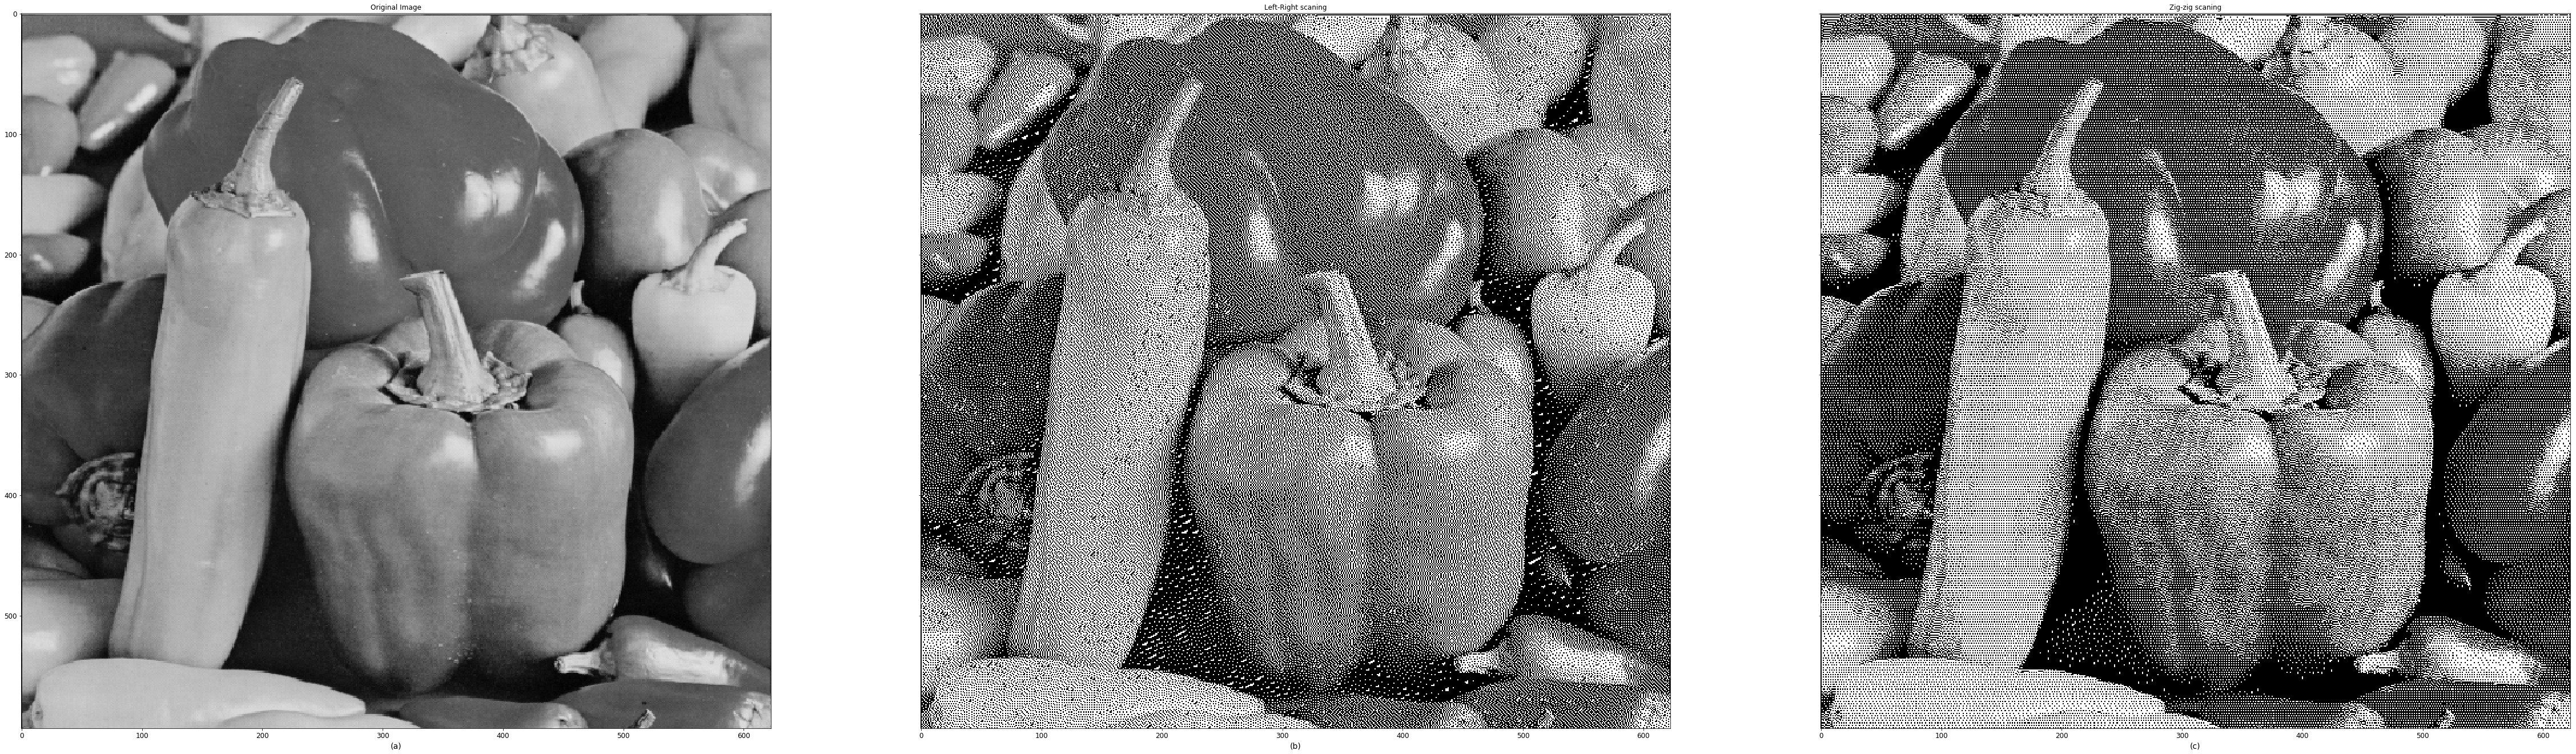

In [31]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(80,50))

ax0.imshow(original_img, cmap='gray')
ax0.set_xlabel("(a)")
ax0.set_title("Original Image")

ax1.imshow(out2, cmap='gray')
ax1.set_xlabel("(b)")
ax1.set_title("Left-Right scaning")

ax2.imshow(out1, cmap='gray')
ax2.set_xlabel("(c)")
ax2.set_title("Zig-zig scaning")

plt.show()

In [32]:
print("Error diffusion (zigzag):",MAE(original_img,out1))
print("Error diffusion (default):",MAE(original_img,out2))

Error diffusion (zigzag): 29924.159684052942
Error diffusion (default): 30221.38462203631


In [33]:
a = np.array([[1,2,3],
        [4,5,6],
        [7,8,9]])
print(a)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [34]:
i=1
j=1

print(a[i,j+1],a[i+1,j-1],a[i+1,j],a[i+1,j+1])

6 7 8 9
